In [1]:
from __future__ import print_function, division
import pandas as pd
import pylab as pl
import os
import json
import urllib2
import sys
import scipy as py
import statsmodels.api as sm
import numpy as np

import matplotlib as mpl
mpl.style.use('classic')

if os.getenv("PUIDATA") is None:
    print ("$PUIDATA to point to set PUIdata dir")

%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [84]:
# load MTA data

mta = np.load(os.getenv('PUIDATA') + '/MTA_Fare.npy')
print ("Dimensions of MTA Ridership Data is " + str(mta.shape))
mta

Dimensions of MTA Ridership Data is (600, 23, 194)


array([[[56961, 64703, 68002, ..., 36527, 33929, 36824],
        [ 1732,  2083,  2107, ...,  1264,  1172,  1238],
        [  203,   276,   245, ...,   186,   167,   167],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0,     0,     0],
        [   -1,    -1,    -1, ...,  1121,  1377,   712]],

       [[16210, 20179, 21769, ...,    -1,    -1,    -1],
        [  503,   647,   665, ...,    -1,    -1,    -1],
        [   41,    43,    44, ...,    -1,    -1,    -1],
        ..., 
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [    0,     0,     0, ...,    -1,    -1,    -1],
        [   -1,    -1,    -1, ...,    -1,    -1,    -1]],

       [[ 3292,  3429,  3629, ...,  3746,  3406,  3217],
        [  110,    92,   102, ...,   212,   209,   211],
        [    7,     6,    13, ...,    26,    20,    22],
        ..., 
        [    0,     0,     0, ...,     0,     0,     0],
        [    0,     0,     0, ...,     0, 

In [3]:
# convert empty (-1) values to NaN
# http://stackoverflow.com/questions/27778299/replace-zeros-in-a-numpy-array-with-nan

mta = mta.astype('float')
mta[mta == -1] = np.nan

In [177]:
# create an array for the ride types

ridetype = np.array(['10t', '14d', '1d', '2t', '30d', '7d', 'ada', 'afas', 'exp','ez',
            'ff','mc','mr','month','rfm','rr','sen','spec','tcmc','t',
            'unlim','xbus','stud'])

In [163]:
# create weekly timeseries from 05/21/2010 to 02/21/2014.

time = pd.date_range(start='05/21/2010', periods=194, freq='W')
time

DatetimeIndex(['2010-05-23', '2010-05-30', '2010-06-06', '2010-06-13',
               '2010-06-20', '2010-06-27', '2010-07-04', '2010-07-11',
               '2010-07-18', '2010-07-25',
               ...
               '2013-12-01', '2013-12-08', '2013-12-15', '2013-12-22',
               '2013-12-29', '2014-01-05', '2014-01-12', '2014-01-19',
               '2014-01-26', '2014-02-02'],
              dtype='datetime64[ns]', length=194, freq='W-SUN')

### While there are 194 weeks of data, the period between 05/21/2010 and 02/21/2014 actually consists of 196 weeks.

In [165]:
# sum time series data for all card types

mta_sum_type = np.nansum(mta, axis=1)
print ("Dimension of MTA ridership array after summing different card types is " + str(mta_sum_type.shape))

Dimension of MTA ridership array after summing different card types is (600, 194)


In [166]:
# average time series data for all stations to create one series for analysis

mta_ave_sta = np.nanmean(mta_sum_type, axis=0)
print ("Dimension of MTA ridership array after finding mean for all stations is " + str(mta_ave_sta.shape))

Dimension of MTA ridership array after finding mean for all stations is (194,)


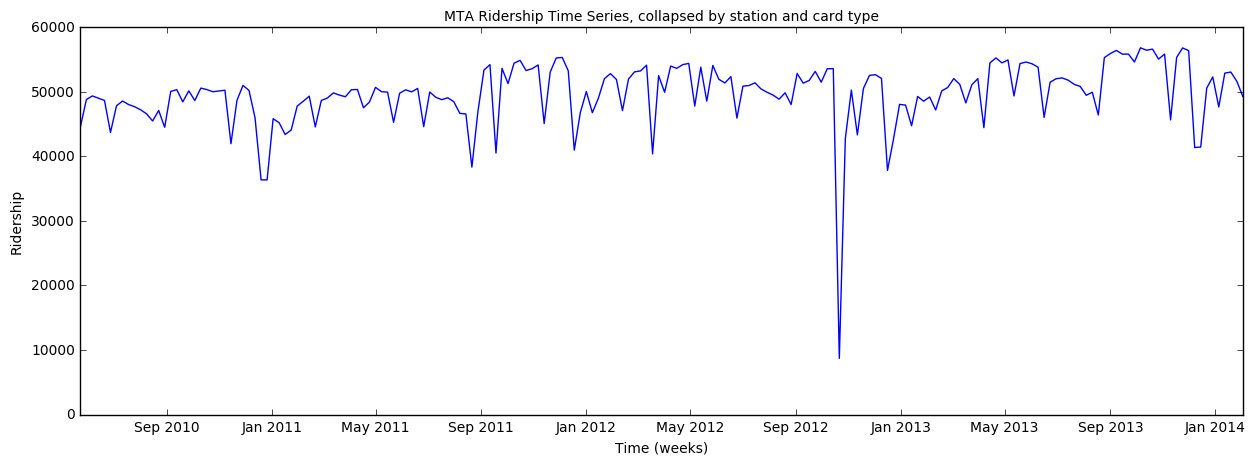

In [251]:
ax = pl.figure(figsize=(15, 5)).add_subplot(111)

mta_event = ax.plot(time, mta_ave_sta)
ax.set_title("MTA Ridership Time Series, collapsed by station and card type", fontsize=10)
pl.xlabel("Time (weeks)", fontsize=10)
pl.ylabel("Ridership", fontsize=10)

### Figure 1 - MTA Rider time series after collapsing by summing card type data and calculating the mean of all stations. The result plot shows an extreme event between Sep 2012 and Jan 2013.

In [11]:
# find week corresponding to extreme event
# http://stackoverflow.com/questions/9850845/how-to-extract-points-from-a-graph

x = mta_event[0].get_xdata()
y = mta_event[0].get_ydata()

idy = np.where(y==np.min(y))
x[idy]

array(['2012-10-21T00:00:00.000000000'], dtype='datetime64[ns]')

### According to the time series, the extreme even occured the week of Oct 21, 2012. This corresponds to the approximate time that Superstorm Sanday made landfall at NYC and Gov. Cuomo ordered closure of the subway on Oct 28. However, there seems to be a bust in the data, which appears to be missing a week of data.

In [169]:
# calculate mean of time series data for all stations by card type

mta_mean_sta = np.nanmean(mta, axis=0)
print ("Dimension of MTA ridership array after calculating the mean of all stations by card type is " + str(mta_mean_sta.shape))

Dimension of MTA ridership array after calculating the mean of all stations by card type is (23, 194)


In [162]:
# calculate the mean of the first and last 10 data points for each series by card type

first_10 = np.nanmean(mta_mean_sta[:, 0:10], axis=1)
last_10 = np.nanmean(mta_mean_sta[:, -11:-1], axis=1)
print(last_10, first_10)

[  2.76711855e+04   1.46823589e+03   1.21922540e+02   3.88970427e+02
   1.11667746e+02   1.20528840e+04   1.78055500e+04   5.19154286e-03
   7.78427655e-03   2.16123373e-03   7.53347800e+01   3.53663653e+02
   3.14617032e+02   1.76575686e+02   1.19902172e+03   3.68270618e+02
   1.98289654e+02   7.10032270e+01   4.06194928e+02   4.65458808e+01
   1.15163430e+01   1.77561944e+00   2.52961080e+03] [  2.66793722e+04   1.15253856e+03   1.07820192e+02   4.11905844e+02
   1.03637043e+02   8.50110772e+03   1.97009743e+04   2.37284521e+01
   7.07624325e+02   1.29474840e+03   8.91427685e+01   2.84984963e+02
   1.25251702e-02   2.96671208e+02   1.82378206e+03   1.39405325e+02
   6.74339178e+01   9.80480102e-01   2.61157398e+02   4.56605879e+01
   1.43175194e+01   1.02890817e+00              nan]


In [178]:
# calculate a ratio of the mean of the last 10 data point over the first 10 for each series by card type

trend_ratio = pd.DataFrame(last_10 / first_10)
trend_ratio = pd.DataFrame.transpose(trend_ratio)
trend_ratio.columns = ridetype
with pd.option_context('display.max_columns', 25):
    print (trend_ratio)

        10t       14d        1d        2t       30d        7d      ada  \
0  1.037175  1.273915  1.130795  0.944319  1.077489  1.417802  0.90379   

       afas       exp        ez        ff        mc            mr    month  \
0  0.000219  0.000011  0.000002  0.845103  1.240991  25118.782983  0.59519   

        rfm        rr       sen       spec      tcmc         t     unlim  \
0  0.657437  2.641726  2.940503  72.416795  1.555364  1.019389  0.804353   

       xbus  stud  
0  1.725732   NaN  


## Interpreting Trend Ratios

A trend ratio is defined as the mean of the last ten values of a time series divided by the mean of the first ten values. Therefore, a trend ratio over 1.0 indicates a possible upward trend, while a ratio less than 1.0 indicates a possible downward trend. In our case, the series showing the most extreme upward trends are for card types "mr" and "spec", while the series showing the most extreme downward trends are for card types "afas", "exp" and "ez". However, we need to visually inspect the data to get an idea of the structure.

In [179]:
# create dataframe for plotting

mta_trends = pd.DataFrame(mta_mean_sta)
mta_trends = pd.DataFrame.transpose(mta_trends)
mta_trends.columns = ridetype
mta_trends.head()

,10t,14d,1d,2t,30d,7d,ada,afas,exp,ez,...,month,rfm,rr,sen,spec,tcmc,t,unlim,xbus,stud
0,19157.461667,883.976667,79.438333,310.688333,77.783333,6162.175000,14252.998333,16.541667,555.098333,853.156667,...,204.993333,1316.620000,99.451667,46.805000,-0.230000,207.591667,34.870000,9.983333,0.366667,-1.0
1,20877.866667,972.323333,85.578333,331.816667,107.023333,6636.115000,15810.425000,19.513333,471.026667,963.140000,...,253.015000,1513.215000,115.116667,53.656667,-0.231667,202.623333,35.885000,9.968333,0.558333,-1.0
2,21277.483333,976.761667,85.831667,332.551667,94.761667,6721.488333,15794.001667,20.233333,503.151667,1025.666667,...,252.335000,1523.311667,115.728333,54.135000,-0.228333,203.406667,35.493333,10.588333,0.546667,-1.0
3,21089.230000,937.441667,86.543333,327.086667,62.153333,6721.026667,15749.906667,18.473333,508.960000,1010.221667,...,244.928333,1504.020000,113.270000,53.778333,-0.228333,203.190000,35.821667,10.755000,0.578333,-1.0
4,21349.263333,914.536667,85.028333,324.578333,58.456667,6542.183333,15489.776667,17.298333,559.406667,938.850000,...,229.586667,1425.728333,110.401667,52.995000,0.066667,199.400000,33.601667,10.295000,0.526667,-1.0


(0.0, 193.0, -0.5, 2.5)

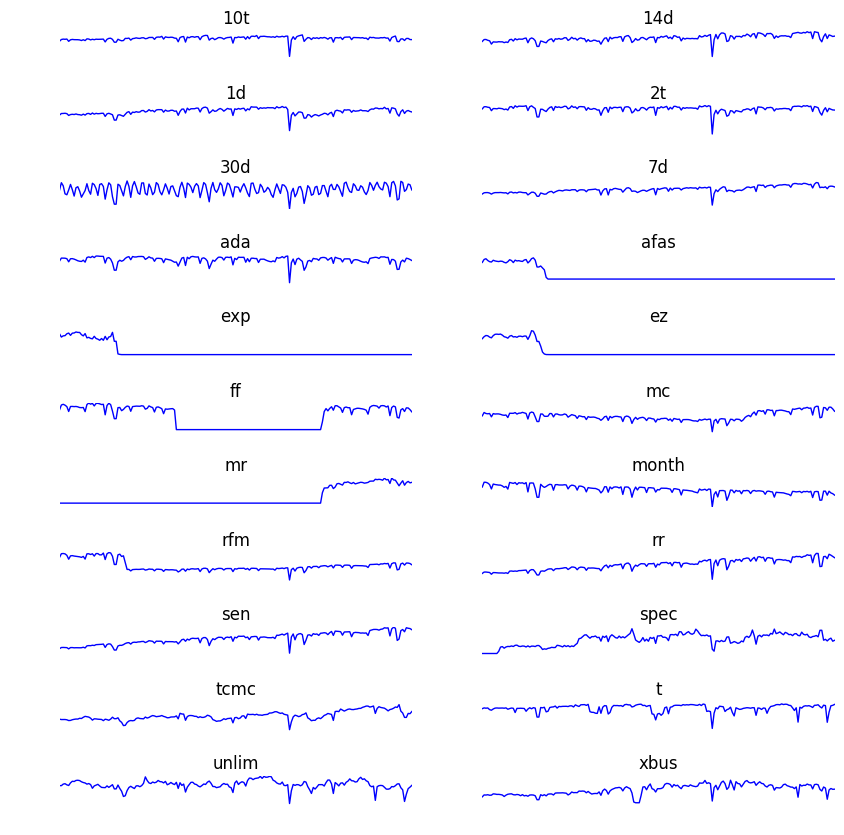

In [217]:
fig, axes = pl.subplots(nrows=11, ncols=2)

fig.subplots_adjust(hspace=1.5)

mta_trends['10t'].plot(ax=axes[0,0]); axes[0,0].set_title('10t'); axes[0,0].axis('off')
mta_trends['14d'].plot(ax=axes[0,1]); axes[0,1].set_title('14d'); axes[0,1].axis('off')

mta_trends['1d'].plot(ax=axes[1,0]); axes[1,0].set_title('1d'); axes[1,0].axis('off')
mta_trends['2t'].plot(ax=axes[1,1]); axes[1,1].set_title('2t'); axes[1,1].axis('off')

mta_trends['30d'].plot(ax=axes[2,0]); axes[2,0].set_title('30d'); axes[2,0].axis('off')
mta_trends['7d'].plot(ax=axes[2,1]); axes[2,1].set_title('7d'); axes[2,1].axis('off')

mta_trends['ada'].plot(ax=axes[3,0]); axes[3,0].set_title('ada'); axes[3,0].axis('off')
mta_trends['afas'].plot(ax=axes[3,1]); axes[3,1].set_title('afas'); axes[3,1].axis('off')

mta_trends['exp'].plot(ax=axes[4,0]); axes[4,0].set_title('exp'); axes[4,0].axis('off')
mta_trends['ez'].plot(ax=axes[4,1]); axes[4,1].set_title('ez'); axes[4,1].axis('off')

mta_trends['ff'].plot(ax=axes[5,0]); axes[5,0].set_title('ff'); axes[5,0].axis('off')
mta_trends['mc'].plot(ax=axes[5,1]); axes[5,1].set_title('mc'); axes[5,1].axis('off')

mta_trends['mr'].plot(ax=axes[6,0]); axes[6,0].set_title('mr'); axes[6,0].axis('off')
mta_trends['month'].plot(ax=axes[6,1]); axes[6,1].set_title('month'); axes[6,1].axis('off')

mta_trends['rfm'].plot(ax=axes[7,0]); axes[7,0].set_title('rfm'); axes[7,0].axis('off')
mta_trends['rr'].plot(ax=axes[7,1]); axes[7,1].set_title('rr'); axes[7,1].axis('off')

mta_trends['sen'].plot(ax=axes[8,0]); axes[8,0].set_title('sen'); axes[8,0].axis('off')
mta_trends['spec'].plot(ax=axes[8,1]); axes[8,1].set_title('spec'); axes[8,1].axis('off')

mta_trends['tcmc'].plot(ax=axes[9,0]); axes[9,0].set_title('tcmc'); axes[9,0].axis('off')
mta_trends['t'].plot(ax=axes[9,1]); axes[9,1].set_title('t'); axes[9,1].axis('off')

mta_trends['unlim'].plot(ax=axes[10,0]); axes[10,0].set_title('unlim'); axes[10,0].axis('off')
mta_trends['xbus'].plot(ax=axes[10,1]); axes[10,1].set_title('xbus'); axes[10,1].axis('off')

### Figure 2 - Sparklines for Time Series by Card Type. After looking at the time series data, we can see that of the card types previously identified, only "spec" contains data for the entire period. The card types afas, exp, ez, ff and mr don't warrant further analysis.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 


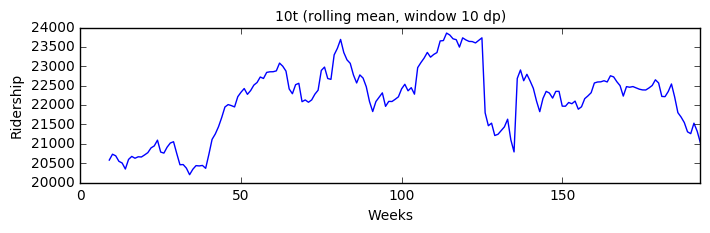

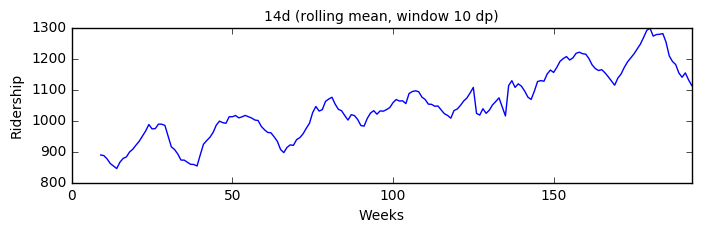

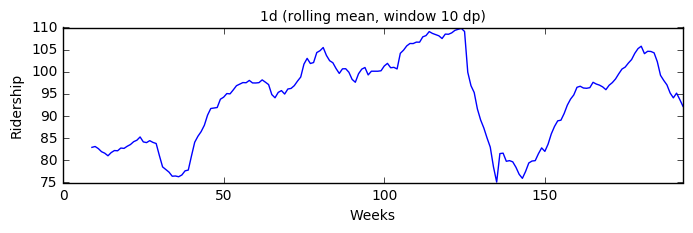

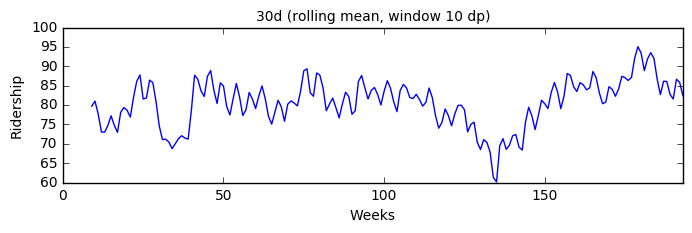

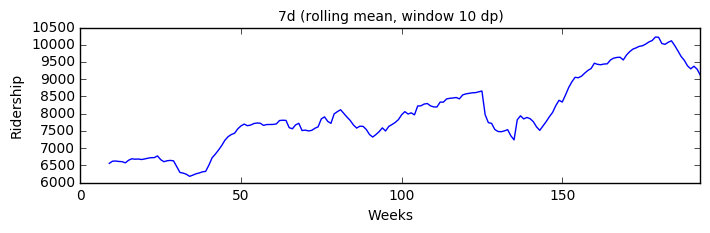

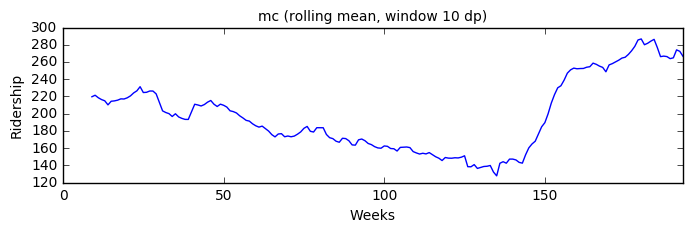

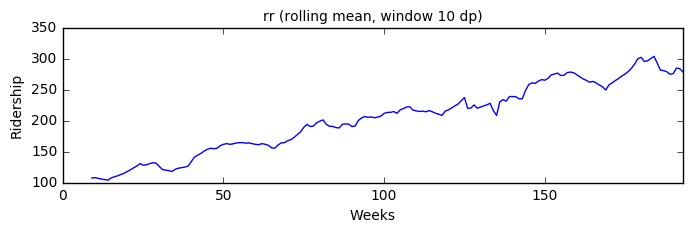

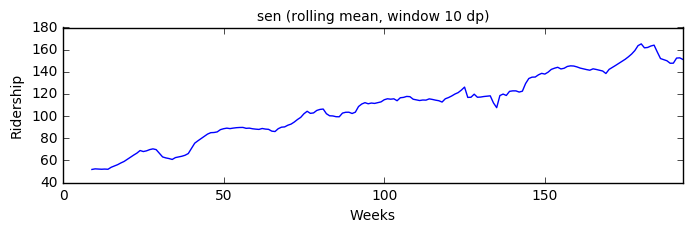

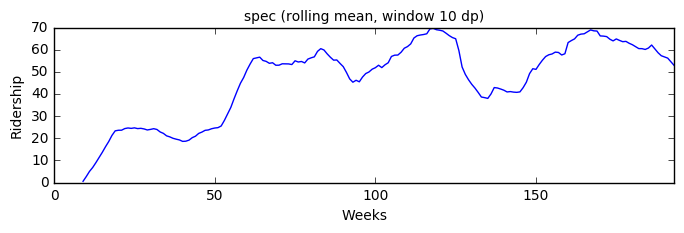

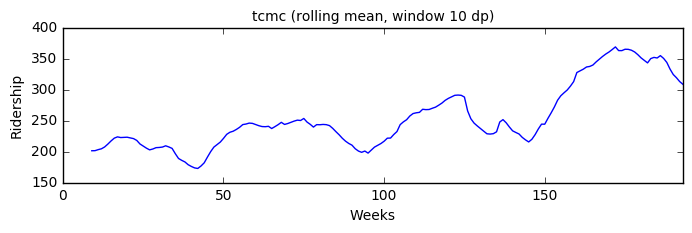

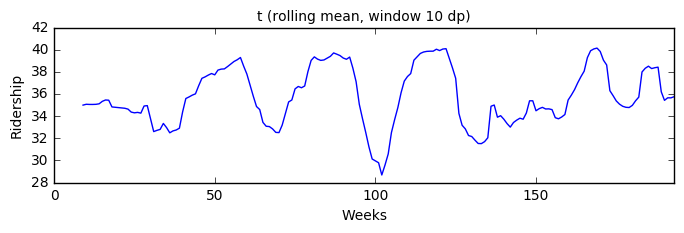

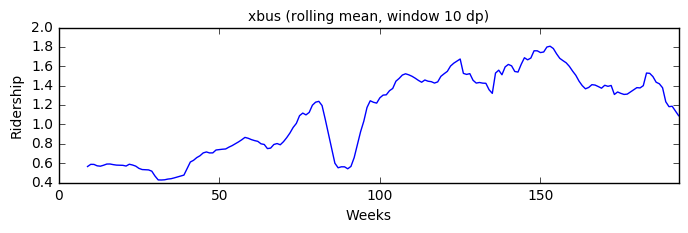

In [216]:
fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['10t'], 10).plot(fontsize=10)
ax.set_title("10t (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['14d'], 10).plot(fontsize=10)
ax.set_title("14d (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['1d'], 10).plot(fontsize=10)
ax.set_title("1d (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['30d'], 10).plot(fontsize=10)
ax.set_title("30d (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['7d'], 10).plot(fontsize=10)
ax.set_title("7d (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['mc'], 10).plot(fontsize=10)
ax.set_title("mc (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['rr'], 10).plot(fontsize=10)
ax.set_title("rr (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['sen'], 10).plot(fontsize=10)
ax.set_title("sen (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['spec'], 10).plot(fontsize=10)
ax.set_title("spec (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['tcmc'], 10).plot(fontsize=10)
ax.set_title("tcmc (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['t'], 10).plot(fontsize=10)
ax.set_title("t (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['xbus'], 10).plot(fontsize=10)
ax.set_title("xbus (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

### Figure 3 - Plots of each card type with a possible upward trend, after using a rolling mean of 10 periods for smoothing. While the "spec" card type has the largest trend ratio (72.4), it's caused by a sharp increase from 0 to 50, after which the trend levels off. Then next two series will the highest ratios are rr (2.64) and sen (2.94), which shown a constant upward trend.

/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:3: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
  app.launch_new_instance()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:11: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:19: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 
	Series.rolling(window=10,center=False).mean()
/opt/rh/anaconda/root/envs/PUI2016_Python2/lib/python2.7/site-packages/ipykernel/__main__.py:27: FutureWarning: pd.rolling_mean is deprecated for Series and will be removed in a future version, replace with 


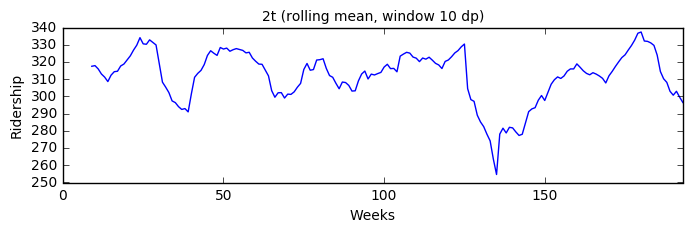

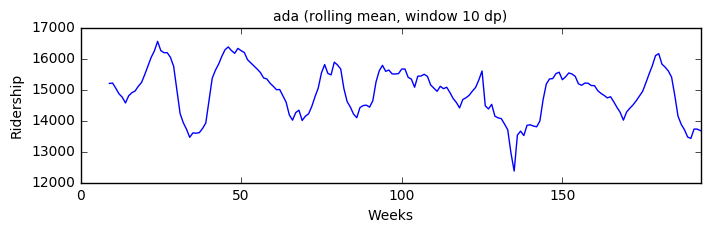

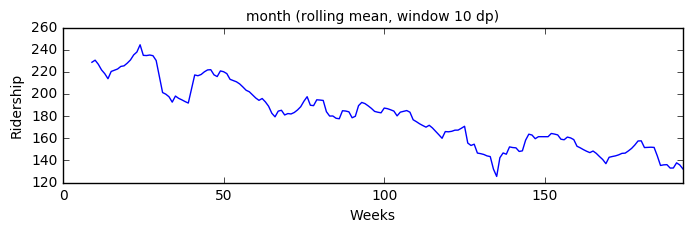

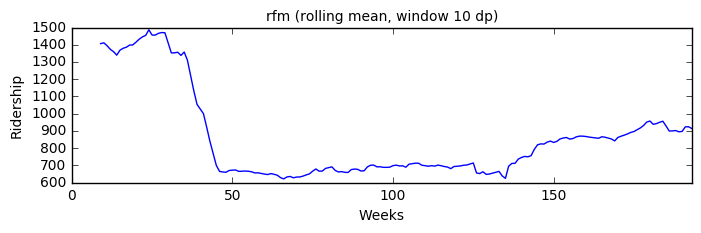

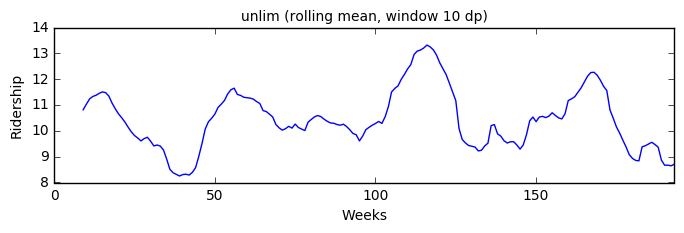

In [220]:
fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['2t'], 10).plot(fontsize=10)
ax.set_title("2t (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['ada'], 10).plot(fontsize=10)
ax.set_title("ada (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['month'], 10).plot(fontsize=10)
ax.set_title("month (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['rfm'], 10).plot(fontsize=10)
ax.set_title("rfm (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

fig = pl.figure(figsize=(8,2))
ax = fig.add_subplot(111)
ax = pd.rolling_mean(mta_trends['unlim'], 10).plot(fontsize=10)
ax.set_title("unlim (rolling mean, window 10 dp)", fontsize=10)
pl.xlabel("Weeks", fontsize=10)
pl.ylabel("Ridership", fontsize=10)
pl.figure()

### Figure 4 - Plots of each card type with a possible downward trend, after using a rolling mean of 10 periods for smoothing. The series for month shows the only constant downward trend.

[0, 200, 3, 8]

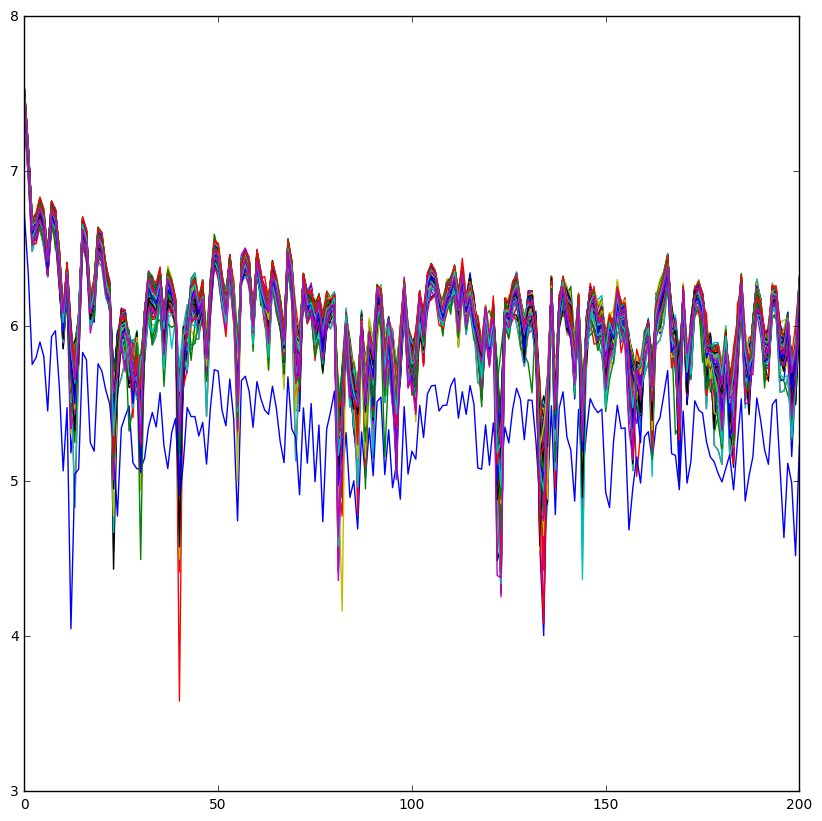

In [242]:
pl.plot(np.log10(np.abs(np.fft.rfft(mta_sum_type, axis=0))))
pl.axis([0, 200, 3, 8])

### I'm having trouble understanding the Fourier portion of this assignment. I'm not sure if this graph is correct or what it means.